# Parallel computing with TaskManager

NGSolve supports shared memory parallelization using its built-in `TaskManager`

In [ ]:
from netgen.csg import unit_cube
from ngsolve import *
from ngsolve.webgui import Draw

In [ ]:
mesh = Mesh(unit_cube.GenerateMesh(maxh=0.2))

In [ ]:
fes = H1(mesh, order=2, dirichlet="left|bottom")
u,v = fes.TnT()
a = BilinearForm(grad(u)*grad(v)*dx)
c = Preconditioner(a, "local")

The `with TaskManager():` statement generates threads which collaborate on the following code block. The main thread executes the Python statements. The work intense NGSolve commands are internally parallelized. For such functions, the main thread generates tasks, which are processed by the available threads. Since the threads are already created, also very short-running functions (in the range of micro-seconds) benefit from parallelization. 

In [ ]:
SetNumThreads(4)
with TaskManager(pajetrace=10**8):

    a.Assemble()

    for l in range(2):
        mesh.Refine()
        fes.Update()
        a.Assemble()
    
    f = LinearForm(1*v*dx).Assemble()
    gfu = GridFunction(fes)
    inv = CGSolver(a.mat, c)
    gfu.vec.data = inv * f.vec

In [ ]:
Draw (gfu);

The argument `pajetrace=10**8` in TaskManager activates tracing. The tracer pre-allocates memory, in this case 100MB, which is used to collect trace data. At the end of the TaskManager clause the data is written to a trace-file in the paje-format. This file can be loaded and visualized by the open source trace explorer vite, available from https://solverstack.gitlabpages.inria.fr/vite/. vite can be installed on Linux by the package manager, compiled vite executables for Windows and MacOS are available from
https://www.asc.tuwien.ac.at/~mhochsteger/files/vite/.

The trace file generated by the code above looks as follows. Time is the horizontal axis, the whole block took 223 milliseconds. The four lines Thread 0 .. Threads 3 visualize the tasks taken by each of the four threads. Below, nested timers are drawn. For example, by clicking on the blue bar in row 'Timer level 0', a dialog box pops up telling that this timer's name is 'Matrix assembling', and took 34 milliseconds. The long red bar is the conjugate gradients solver, the small chunks within are matrix-vector products, and vector operations.

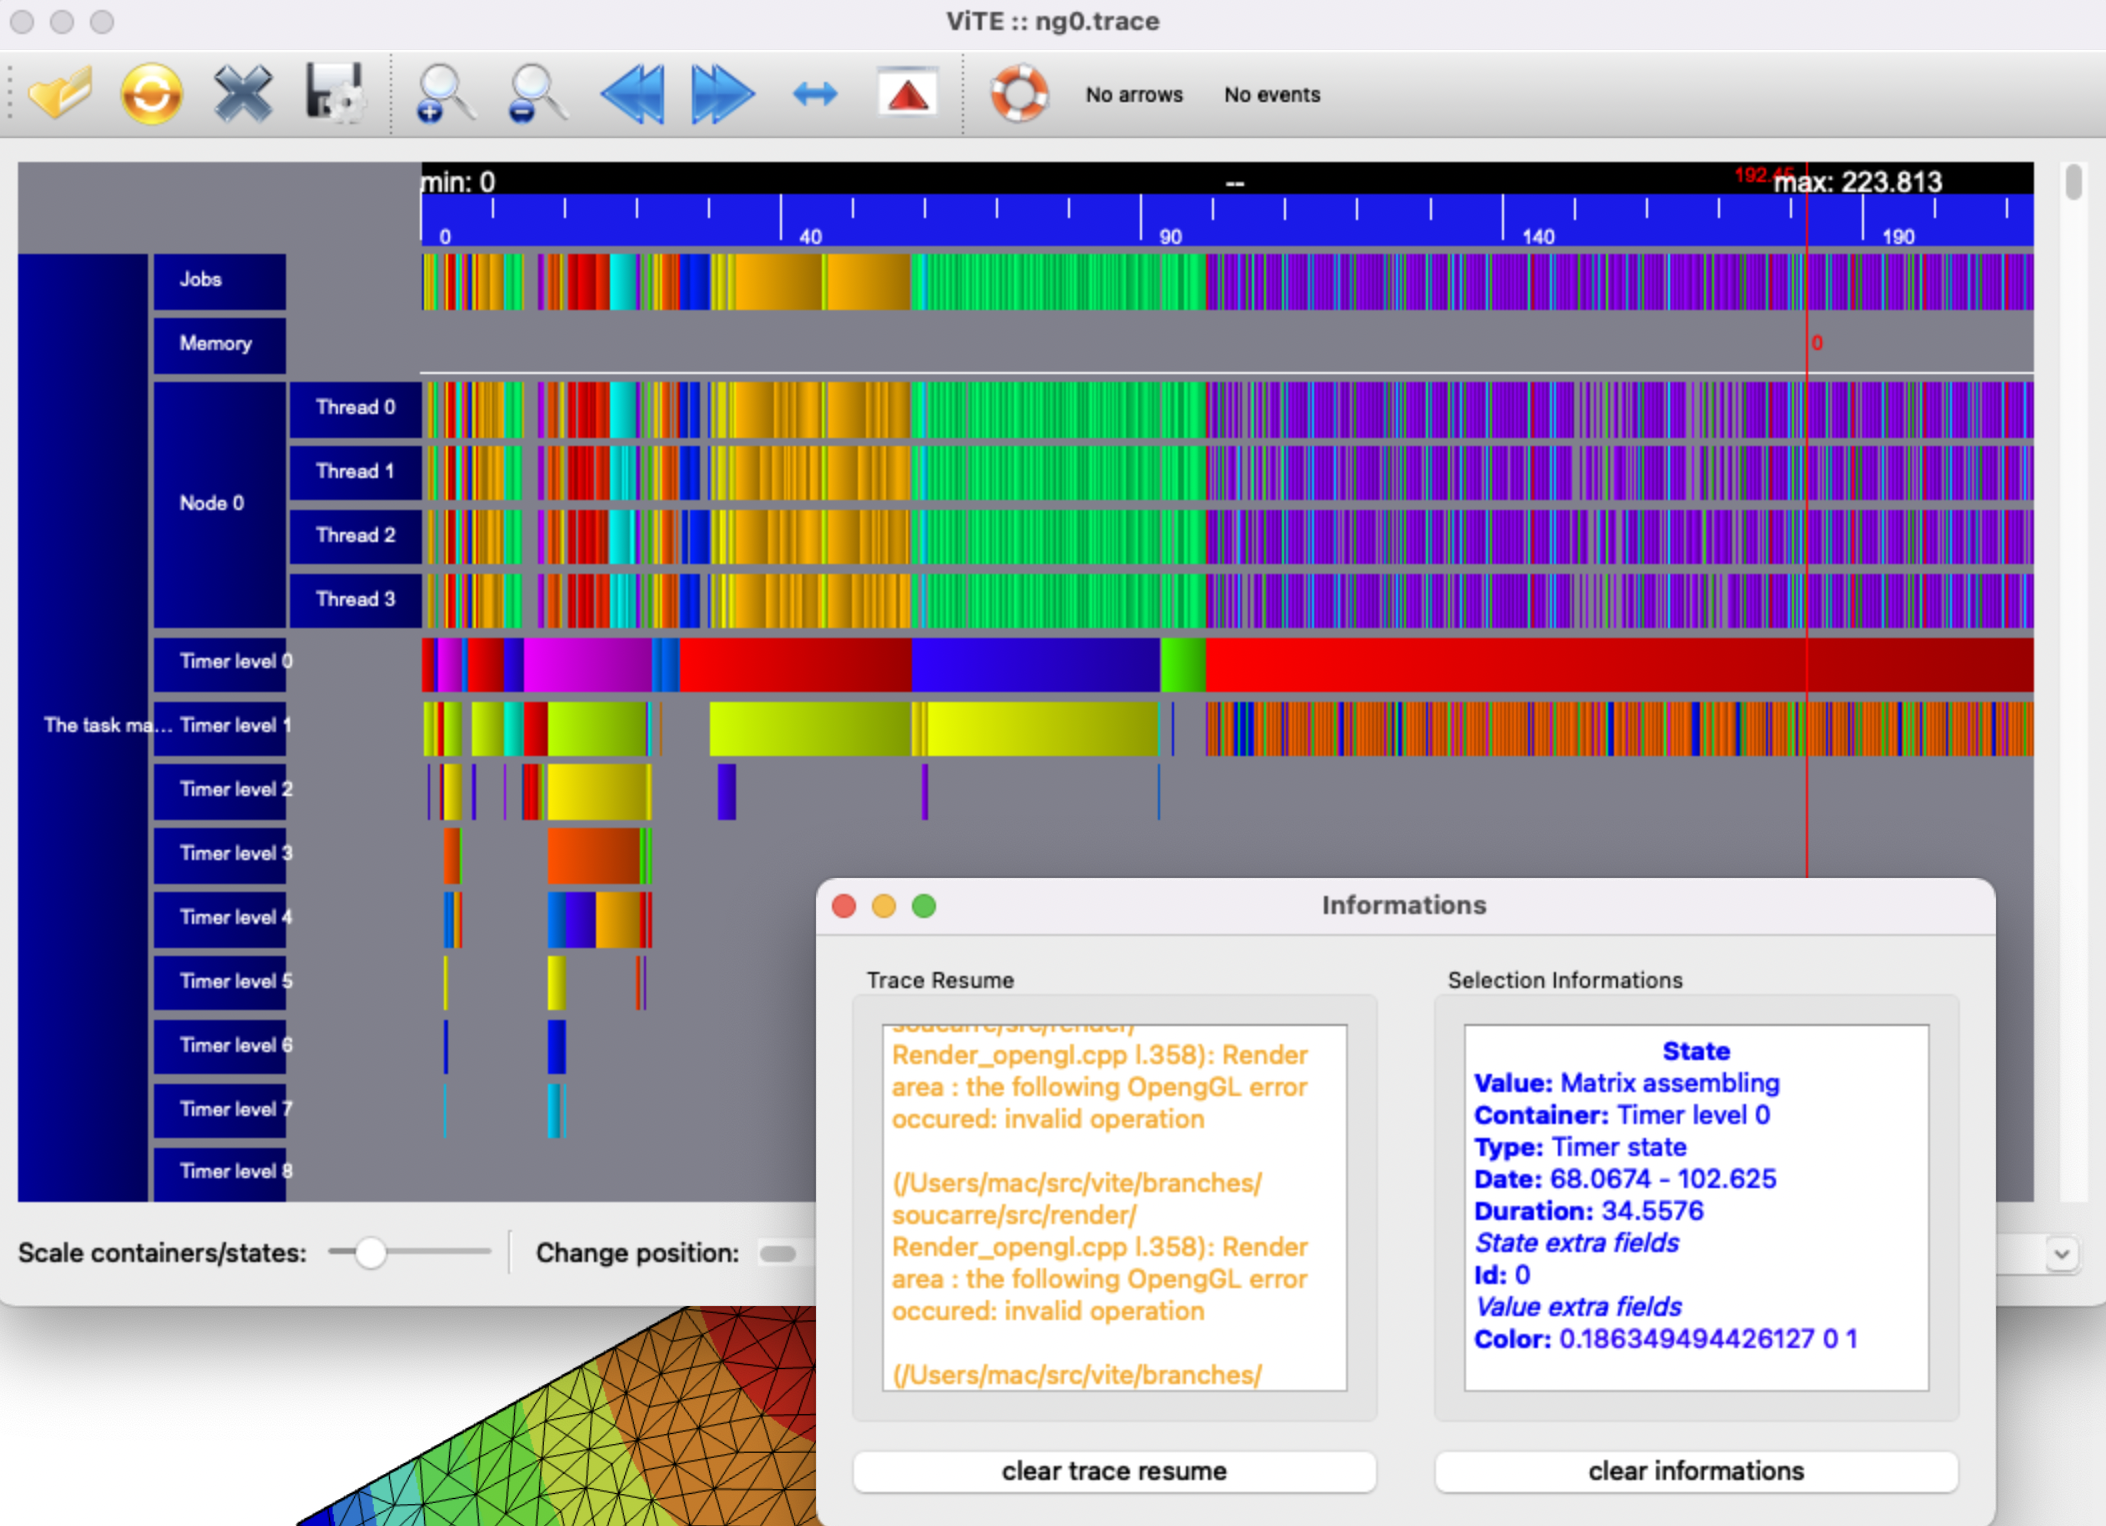